# Explore DRAGON results

# 1. Initialisation

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import AutoMinorLocator

import numpy as np
import os

from astropy.io import fits

## Observations

In [2]:
data_dir = 'Data_files'

H and He:

In [3]:
data = os.path.join(data_dir, 'prot_AMS_2011-2013.dat')
Emeanp, Emeanp_low, Emeanp_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxp, fluxp_low, fluxp_up = np.loadtxt(data,skiprows=0,usecols=(3, 8, 9), unpack=True)
errfluxp = (fluxp_low + fluxp_up)/2

data = os.path.join(data_dir, 'p_flux_ATIC2009.txt')
EmeanAT, EmeanAT_low, EmeanAT_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxAT, fluxAT_low, fluxAT_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)
errfluxAT = (fluxAT_low + fluxAT_up)/2

data = os.path.join(data_dir, 'p_flux_CREAMIII_ApJ2017.txt')
EmeanCR, EmeanCR_low, EmeanCR_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxCR, fluxCR_low, fluxCR_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)
errfluxCR = (fluxCR_low + fluxCR_up)/2

data = os.path.join(data_dir, 'DAMPE_protons.txt')
EmeanDA, EmeanDA_low, EmeanDA_up = np.loadtxt(data,skiprows=1,usecols=(1, 0, 2), unpack=True)
fluxDA, fluxDA_low, fluxDA_up = np.loadtxt(data,skiprows=1,usecols=(4, 3, 5), unpack=True)
errfluxDA = (fluxDA_low + fluxDA_up)/2

data = os.path.join(data_dir, 'He_AMS_2011-2013.dat')
EmeanHe, EmeanHe_low, EmeanHe_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxHe, fluxHe_low, fluxHe_up = np.loadtxt(data,skiprows=0,usecols=(3, 8, 9), unpack=True)
errfluxHe = (fluxHe_low + fluxHe_up)/2

C

In [4]:
data = os.path.join(data_dir, 'C_AMS_PRL2017.txt')
EmeanC, EmeanC_low, EmeanC_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxC, fluxC_low, fluxC_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)
errfluxC = (fluxC_low + fluxC_up)/2

myZ = 6
data = os.path.join(data_dir, 'apjaa2409t9_ascii.txt') 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z == myZ]
errfluxA = np.sqrt(sys**2 + sig**2)[Z==myZ]
fluxA = 1e3*fluxA[Z==myZ]

Emean_min = (1e-3 * Emean_min[Z==myZ])
Emean_max = (1e-3 * Emean_max[Z==myZ])

Emean_min = EmeanA - Emean_min
Emean_max = Emean_max - EmeanA

EmeanA = EmeanA


O

In [5]:
data = os.path.join(data_dir, 'O_AMS_PRL2017.txt') 
EmeanO, EmeanO_low, EmeanO_up = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2), unpack=True)
fluxO, fluxO_low, fluxO_up = np.loadtxt(data,skiprows=0,usecols=(3, 4, 5), unpack=True)

errfluxO = (fluxO_low + fluxO_up)/2

myZ = 8
data = os.path.join(data_dir, 'apjaa2409t9_ascii.txt') 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z == myZ]
errfluxA = np.sqrt(sys**2 + sig**2)[Z==myZ]
fluxA = 1e3*fluxA[Z==myZ]

Emean_min = (1e-3 * Emean_min[Z==myZ])
Emean_max = (1e-3 * Emean_max[Z==myZ])

Emean_min = EmeanA - Emean_min
Emean_max = Emean_max - EmeanA

EmeanA = EmeanA

B/C

In [6]:
data = os.path.join(data_dir, 'B_C_ratio_AMS_PRL2018.txt')
EmeanBC = np.loadtxt(data,skiprows=0,usecols=(0,))
fluxBC, fluxBC_low, fluxBC_up = np.loadtxt(data,skiprows=0,usecols=(3,4, 5), unpack=True)
errfluxBC = (fluxBC_low + fluxBC_up)/2


## Voyager data
def voyerr(a, b, da, db):
    if ((type(a) != np.ndarray) or (type(b) != np.ndarray) or 
        (type(da) != np.ndarray) or (type(db) != np.ndarray)):
        print("Error, the Fluxes (Energies) and errFluxes (ErrEnergies) must be an array")
    return np.sqrt((da/b)**2 + (-a*db/b**2)**2)


MyZ = 6
data = os.path.join(data_dir, 'apjaa2409t9_ascii.txt') 
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA2, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA2 = (1e-3*(0.5*(Emean_min + Emean_max)))[Z ==MyZ]

errfluxA2 = (np.sqrt(sys**2 + sig**2))[Z==MyZ]
fluxA2 = 1e3*fluxA2[Z==MyZ]

errfluxA2 = (errfluxA2[EmeanA2 > 0.01])
fluxA2 = fluxA2[EmeanA2>0.01]

Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA2>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA2>0.01]

Emean_minA2 = EmeanA2[EmeanA2>0.01] - Emean_min
Emean_maxA2 = Emean_max - EmeanA2[EmeanA2>0.01] 

EmeanA2 = EmeanA2[EmeanA2>0.01]


MyZ = 5
data = os.path.join(data_dir, 'apjaa2409t9_ascii.txt') # ϕ=564 ± 26 MV
Z, Emean_min, Emean_max = np.loadtxt(data,skiprows=4,usecols=(0, 1, 2), unpack=True)
fluxA, sig, sys = np.loadtxt(data,skiprows=4,usecols=(3, 4, 5), unpack=True)
EmeanA = (1e-3*(0.5*(Emean_min + Emean_max)))[Z==MyZ]
errfluxA = 1e3*np.sqrt(sys**2 + sig**2)[Z==MyZ]
fluxA = 1e3*fluxA[Z==MyZ]

errfluxA = (errfluxA[EmeanA > 0.01])
fluxA = fluxA[EmeanA>0.01]
Emean_min = (1e-3 * Emean_min[Z==MyZ])[EmeanA>0.01]
Emean_max = (1e-3 * Emean_max[Z==MyZ])[EmeanA>0.01]

Emean_min = EmeanA[EmeanA>0.01] - Emean_min
Emean_max = Emean_max - EmeanA[EmeanA>0.01] 

EmeanA = EmeanA[EmeanA>0.01]
Etot = np.sort(list(EmeanBC)+ list(EmeanA))

fluxA2_new = np.interp(EmeanA, EmeanA2, fluxA2)
errfluxA2_new = np.interp(EmeanA, EmeanA2, errfluxA2)
EnerrA2 = 0.5*(Emean_minA2 + Emean_maxA2)
errEnA2_new = np.interp(EmeanA, EmeanA2, EnerrA2)

fluxerr = voyerr(fluxA, fluxA2_new, errfluxA, errfluxA2_new)
EnerrA = 0.5*(Emean_min + Emean_max)
Enerr = voyerr(fluxA, fluxA2_new, EnerrA, errEnA2_new)




## DRAGON output

In [7]:
output_dir = 'output'

In [25]:
particle_names = {
    'Z=-1_A=0': r'e$^-$',
    'Z=1_A=0': r'e$^+$',
    'Z=-1_A=1': r'$\bar{p}$',
    'Z=1_A=1': r'p',
    'Z=1_A=2': r'$^2$H',
    'Z=1_A=3': r'$^3$H',
    'Z=2_A=3': r'$^3$He',
    'Z=2_A=4': r'$^4$He',
}

In [26]:
class DRAGON_run(object):
    
    def __init__(self, model_name):
        self.name = model_name
        print('Reading DRAGON model:', model_name)
        hdulist = fits.open(os.path.join(output_dir, f'{model_name}.fits.gz'))
        #hdulist.info()
        h = hdulist[0].header
        #for key in h:
        #    print(f'{key:10s} = {h[key]}')
        self.grid_E = np.logspace(np.log10(h['EKMIN']), np.log10(h['EKMAX']), h['NAXIS1'])
        self.grid_R = np.linspace(h['RMIN'], h['RMAX'], h['NAXIS2'])
        self.grid_z = np.linspace(h['ZMIN'], h['ZMAX'], h['NAXIS3'])
        self.izsun = h['izsun']
        self.irsun = h['irsun']
        #print(f"(R, z)_sun = ({grid_R[irsun]}, {grid_z[izsun]}) ~ ({h['robs']}, {h['zobs']})")
        
        self.spectra = {}
        for i, hdu in enumerate(hdulist[1:]):
            if hdu.header['SEC']:
                origin = "secondary"
            elif hdu.header['DM']:
                origin = "DM"
            elif hdu.header['EXTRA']:
                origin = "extra"
            else:
                origin = "primary"
            particle = f"Z={hdu.header['Z_']}_A={hdu.header['A']}"
            self.spectra[f'{origin} {particle_names.get(particle, particle)}'] = hdu.data
        #for particle in self.spectra:
        #    print(' -', particle)


    def plot_map(self, species, E, ax):
        energy = np.searchsorted(self.grid_E, E)
        data = self.spectra[species][:, :, energy]
        p1, p99 = np.nanpercentile(data, [1, 99])
        im = ax.imshow(data,
                       extent=(self.grid_R[0], self.grid_R[-1], self.grid_z[0], self.grid_z[-1]),
                       origin='lower', interpolation='nearest',
                       cmap='inferno',
                       norm=colors.LogNorm(vmin=max(p1, 1e-4*p99), vmax=p99),
                      )
        ax.set_aspect('auto')
        ax.scatter(self.grid_R[self.irsun], self.grid_z[self.izsun], s=5, color='k')
        ax.scatter(self.grid_R[self.irsun], self.grid_z[self.izsun], s=50, facecolor='none', edgecolor='k')
        cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9, fraction=.2)
        ax.legend(title=self.name, loc='upper center')



In [36]:
#model_names = ['run_2D_DM_0', 'run_2D_DM_1', 'run_2D_DM_2']
model_names = ['run_2D_DM', 'run_2D_DM_Delta=0.4', 'run_2D_DM_Delta=0.8']
models = []
for name in model_names:
    models.append(DRAGON_run(name))
n_models = len(models)

Reading DRAGON model: run_2D_DM
Reading DRAGON model: run_2D_DM_Delta=0.4
Reading DRAGON model: run_2D_DM_Delta=0.8


# 2. Plots

## Map

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


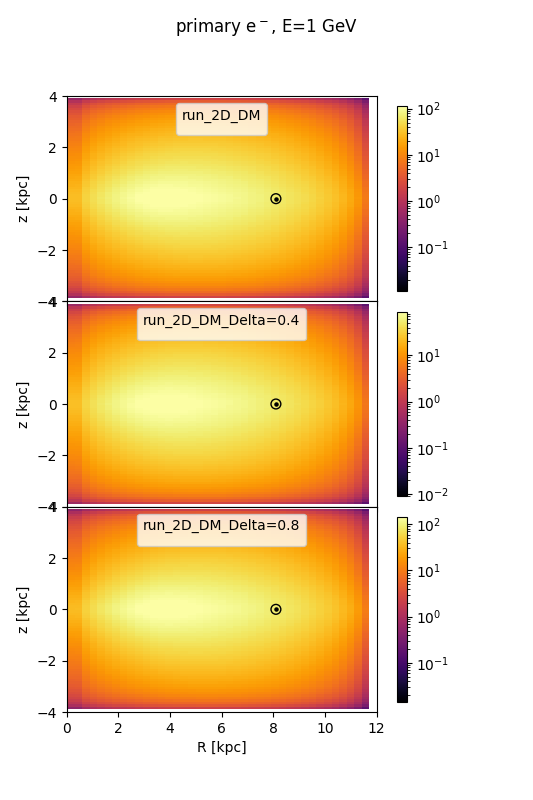

In [37]:
fig_name='map'
plt.close(fig_name)

panel_size = 8/n_models
fig = plt.figure(fig_name, figsize=(np.clip(2*panel_size, 4, 12), 8))
axes = fig.subplots(nrows=n_models, ncols=1, squeeze=False,
                    sharex=True, sharey=True,
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )

species = 'primary e$^-$'
energy = 1
fig.suptitle(f'{species}, E={energy} GeV')

for i, model in enumerate(models):
    ax = axes[i, 0]
    model.plot_map(species, energy, ax)
    ax.set_ylabel('z [kpc]')

axes[-1, 0].set_xlabel('R [kpc]')
plt.show()

proton spectrum

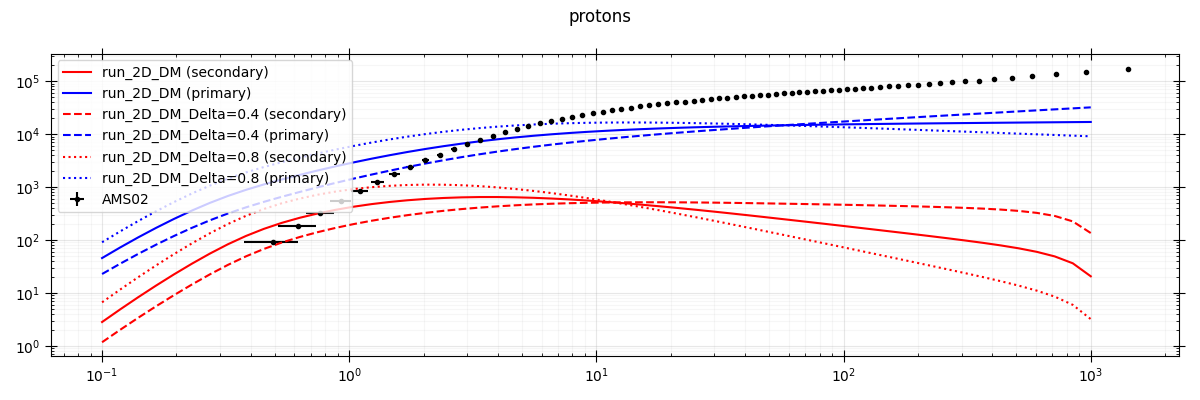

In [38]:
alpha_norm = 3.1
color = {'primary': 'b', 'secondary': 'r', 'DM': 'k', 'extra': 'k'}
style = ['-', '--', ':', '-.']

fig_name = 'protons'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(fig_name)
for ax in axes.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
    ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
    ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
    ax.grid(True, which='both')


ax = axes[0, 0]

norm = np.power(Emeanp, alpha_norm)
ax.errorbar(Emeanp, norm*fluxp,
            xerr=[(Emeanp-Emeanp_low)/Emeanp, (Emeanp_up-Emeanp)/Emeanp],
            yerr=[norm*fluxp_low, norm*fluxp_up],
            fmt= 'k.', label = "AMS02")  # Real data

particle_to_plot = 'p'
for i, model in enumerate(models):
    norm = np.power(model.grid_E, alpha_norm)
    for species in model.spectra:
        #print(species, species.split())
        origin, particle = species.split()
        if particle == particle_to_plot:
            data = model.spectra[species][model.izsun, model.irsun]
            ax.plot(model.grid_E, norm*data, c=color[origin], ls=style[i], label=f'{model.name} ({origin})')

#ax.errorbar(EmeanHe, fluxHe*np.power(EmeanHe, 3.1), xerr = [(EmeanHe-EmeanHe_low)/EmeanHe, (EmeanHe_up-EmeanHe)/EmeanHe], yerr = [fluxHe_low*np.power(EmeanHe, 3.1), fluxHe_up*np.power(EmeanHe, 3.1)], fmt= '*b', label = "Helium AMS02 data") #Real data

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

plt.show()